<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


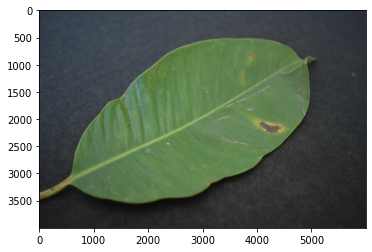

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

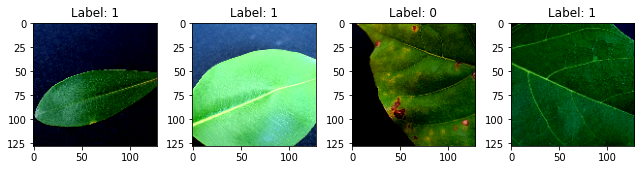

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.252806195236172 samples/sec                   batch loss = 0.9177606105804443 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2687476471715466 samples/sec                   batch loss = 0.8573619723320007 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2658199807907482 samples/sec                   batch loss = 0.3700263202190399 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2544524187919444 samples/sec                   batch loss = 1.4430738687515259 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2566344531369842 samples/sec                   batch loss = 0.9952439665794373 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2560546377107262 samples/sec                   batch loss = 0.1990450918674469 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2222663952755863 samples/sec                   batch loss = 0.9031378626823425 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2644469704083876 samples/sec                   batch loss = 0.4326692521572113 | accuracy = 0.65


Epoch[1] Batch[45] Speed: 1.254570238764592 samples/sec                   batch loss = 0.758721113204956 | accuracy = 0.6444444444444445


Epoch[1] Batch[50] Speed: 1.2629901231785325 samples/sec                   batch loss = 0.9563261270523071 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2569845959371382 samples/sec                   batch loss = 0.33677637577056885 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2627064741605354 samples/sec                   batch loss = 0.35476452112197876 | accuracy = 0.6416666666666667


Epoch[1] Batch[65] Speed: 1.26538577515628 samples/sec                   batch loss = 1.1497528553009033 | accuracy = 0.6423076923076924


Epoch[1] Batch[70] Speed: 1.2553137840014161 samples/sec                   batch loss = 0.1486998349428177 | accuracy = 0.6571428571428571


Epoch[1] Batch[75] Speed: 1.2577755120400635 samples/sec                   batch loss = 0.8616325259208679 | accuracy = 0.6566666666666666


Epoch[1] Batch[80] Speed: 1.2646125237766632 samples/sec                   batch loss = 0.6798722743988037 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.2633517132062115 samples/sec                   batch loss = 0.3905324637889862 | accuracy = 0.6588235294117647


Epoch[1] Batch[90] Speed: 1.2679338687703452 samples/sec                   batch loss = 0.35375434160232544 | accuracy = 0.6611111111111111


Epoch[1] Batch[95] Speed: 1.263085683792825 samples/sec                   batch loss = 0.8937424421310425 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2647622930341949 samples/sec                   batch loss = 0.5196786522865295 | accuracy = 0.64


Epoch[1] Batch[105] Speed: 1.2703978693755216 samples/sec                   batch loss = 0.8586856126785278 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2653706959698119 samples/sec                   batch loss = 0.6527162194252014 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.2602492808138324 samples/sec                   batch loss = 0.6612874865531921 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.257388646429593 samples/sec                   batch loss = 0.8364020586013794 | accuracy = 0.6416666666666667


Epoch[1] Batch[125] Speed: 1.2584113782866264 samples/sec                   batch loss = 0.4528812766075134 | accuracy = 0.648


Epoch[1] Batch[130] Speed: 1.2610168248159985 samples/sec                   batch loss = 0.7715551853179932 | accuracy = 0.6461538461538462


Epoch[1] Batch[135] Speed: 1.2493751901275534 samples/sec                   batch loss = 0.7680286169052124 | accuracy = 0.6518518518518519


Epoch[1] Batch[140] Speed: 1.252616689818038 samples/sec                   batch loss = 0.6769328117370605 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2560880216100958 samples/sec                   batch loss = 0.5809692144393921 | accuracy = 0.6448275862068965


Epoch[1] Batch[150] Speed: 1.25778918489158 samples/sec                   batch loss = 0.7022675275802612 | accuracy = 0.6466666666666666


Epoch[1] Batch[155] Speed: 1.2585397616029166 samples/sec                   batch loss = 0.8152574300765991 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2627131266661002 samples/sec                   batch loss = 0.23206037282943726 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.2656900124636081 samples/sec                   batch loss = 0.7710379362106323 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.2650003189415544 samples/sec                   batch loss = 0.32225269079208374 | accuracy = 0.65


Epoch[1] Batch[175] Speed: 1.2627752834621921 samples/sec                   batch loss = 0.39602357149124146 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.2649016074229325 samples/sec                   batch loss = 0.5214853882789612 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2648657508212626 samples/sec                   batch loss = 0.27849599719047546 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2610790990913388 samples/sec                   batch loss = 0.3570217490196228 | accuracy = 0.6605263157894737


Epoch[1] Batch[195] Speed: 1.255248602911403 samples/sec                   batch loss = 0.599281907081604 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.2621350005909246 samples/sec                   batch loss = 0.19712799787521362 | accuracy = 0.665


Epoch[1] Batch[205] Speed: 1.2637899500727665 samples/sec                   batch loss = 0.825096070766449 | accuracy = 0.6658536585365854


Epoch[1] Batch[210] Speed: 1.2628704313275152 samples/sec                   batch loss = 0.5418280363082886 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.2629040834552285 samples/sec                   batch loss = 0.19963178038597107 | accuracy = 0.672093023255814


Epoch[1] Batch[220] Speed: 1.2674132803439475 samples/sec                   batch loss = 0.38261252641677856 | accuracy = 0.6738636363636363


Epoch[1] Batch[225] Speed: 1.2677400468914963 samples/sec                   batch loss = 0.28681522607803345 | accuracy = 0.6766666666666666


Epoch[1] Batch[230] Speed: 1.2605907381096912 samples/sec                   batch loss = 0.4079230725765228 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2570728449986273 samples/sec                   batch loss = 0.7037845253944397 | accuracy = 0.6776595744680851


Epoch[1] Batch[240] Speed: 1.265507948904822 samples/sec                   batch loss = 0.6091814637184143 | accuracy = 0.68125


Epoch[1] Batch[245] Speed: 1.269751180561258 samples/sec                   batch loss = 0.29411834478378296 | accuracy = 0.6816326530612244


Epoch[1] Batch[250] Speed: 1.2632624852767476 samples/sec                   batch loss = 0.4711374044418335 | accuracy = 0.683


Epoch[1] Batch[255] Speed: 1.2621482936316308 samples/sec                   batch loss = 0.712724506855011 | accuracy = 0.6813725490196079


Epoch[1] Batch[260] Speed: 1.2592595706097989 samples/sec                   batch loss = 0.30692657828330994 | accuracy = 0.6778846153846154


Epoch[1] Batch[265] Speed: 1.267617633356539 samples/sec                   batch loss = 0.4385612905025482 | accuracy = 0.6773584905660377


Epoch[1] Batch[270] Speed: 1.2599090492100906 samples/sec                   batch loss = 0.34567853808403015 | accuracy = 0.6796296296296296


Epoch[1] Batch[275] Speed: 1.2572722751164387 samples/sec                   batch loss = 0.441786527633667 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.263191435375681 samples/sec                   batch loss = 0.5689765810966492 | accuracy = 0.6803571428571429


Epoch[1] Batch[285] Speed: 1.254528211267099 samples/sec                   batch loss = 0.2484695315361023 | accuracy = 0.6815789473684211


Epoch[1] Batch[290] Speed: 1.2574631919246975 samples/sec                   batch loss = 0.4328119456768036 | accuracy = 0.6810344827586207


Epoch[1] Batch[295] Speed: 1.259416583173309 samples/sec                   batch loss = 0.721991777420044 | accuracy = 0.6805084745762712


Epoch[1] Batch[300] Speed: 1.263960568735004 samples/sec                   batch loss = 1.0131754875183105 | accuracy = 0.6808333333333333


Epoch[1] Batch[305] Speed: 1.2620354066444328 samples/sec                   batch loss = 0.5830602645874023 | accuracy = 0.680327868852459


Epoch[1] Batch[310] Speed: 1.266208899212443 samples/sec                   batch loss = 0.6083171367645264 | accuracy = 0.682258064516129


Epoch[1] Batch[315] Speed: 1.2655129127120368 samples/sec                   batch loss = 0.42587605118751526 | accuracy = 0.6841269841269841


Epoch[1] Batch[320] Speed: 1.2718587532502976 samples/sec                   batch loss = 0.3966381847858429 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.2699859930152806 samples/sec                   batch loss = 0.36169949173927307 | accuracy = 0.683076923076923


Epoch[1] Batch[330] Speed: 1.2747875242177638 samples/sec                   batch loss = 0.404198557138443 | accuracy = 0.6848484848484848


Epoch[1] Batch[335] Speed: 1.2708233931206747 samples/sec                   batch loss = 0.3513737618923187 | accuracy = 0.685820895522388


Epoch[1] Batch[340] Speed: 1.2654893349745686 samples/sec                   batch loss = 1.6531398296356201 | accuracy = 0.6838235294117647


Epoch[1] Batch[345] Speed: 1.2633013901482586 samples/sec                   batch loss = 0.392986536026001 | accuracy = 0.6826086956521739


Epoch[1] Batch[350] Speed: 1.266740549476088 samples/sec                   batch loss = 0.3980257213115692 | accuracy = 0.6828571428571428


Epoch[1] Batch[355] Speed: 1.2746071917400257 samples/sec                   batch loss = 1.9646992683410645 | accuracy = 0.6830985915492958


Epoch[1] Batch[360] Speed: 1.273859869473754 samples/sec                   batch loss = 0.269367516040802 | accuracy = 0.6847222222222222


Epoch[1] Batch[365] Speed: 1.2664773932506237 samples/sec                   batch loss = 0.3438672125339508 | accuracy = 0.6863013698630137


Epoch[1] Batch[370] Speed: 1.2606016306686896 samples/sec                   batch loss = 0.37885433435440063 | accuracy = 0.6864864864864865


Epoch[1] Batch[375] Speed: 1.2655667534304587 samples/sec                   batch loss = 0.9949158430099487 | accuracy = 0.686


Epoch[1] Batch[380] Speed: 1.2668123818159756 samples/sec                   batch loss = 0.5209293961524963 | accuracy = 0.6875


Epoch[1] Batch[385] Speed: 1.2675580634905668 samples/sec                   batch loss = 0.5439561009407043 | accuracy = 0.6844155844155844


Epoch[1] Batch[390] Speed: 1.2655405961971964 samples/sec                   batch loss = 0.28107836842536926 | accuracy = 0.6865384615384615


Epoch[1] Batch[395] Speed: 1.2661426773565558 samples/sec                   batch loss = 0.4468066394329071 | accuracy = 0.6867088607594937


Epoch[1] Batch[400] Speed: 1.2644504011264068 samples/sec                   batch loss = 0.2006283402442932 | accuracy = 0.68875


Epoch[1] Batch[405] Speed: 1.267921603444845 samples/sec                   batch loss = 0.37826424837112427 | accuracy = 0.6895061728395062


Epoch[1] Batch[410] Speed: 1.2648361897264537 samples/sec                   batch loss = 0.39029791951179504 | accuracy = 0.6908536585365853


Epoch[1] Batch[415] Speed: 1.2672292849541025 samples/sec                   batch loss = 0.29301416873931885 | accuracy = 0.6927710843373494


Epoch[1] Batch[420] Speed: 1.2607259138848945 samples/sec                   batch loss = 0.545037031173706 | accuracy = 0.6934523809523809


Epoch[1] Batch[425] Speed: 1.2629849889876985 samples/sec                   batch loss = 0.3553355634212494 | accuracy = 0.6941176470588235


Epoch[1] Batch[430] Speed: 1.2604154411637654 samples/sec                   batch loss = 1.412777066230774 | accuracy = 0.6924418604651162


Epoch[1] Batch[435] Speed: 1.2618959635568958 samples/sec                   batch loss = 0.4134201407432556 | accuracy = 0.6925287356321839


Epoch[1] Batch[440] Speed: 1.2607680734378741 samples/sec                   batch loss = 0.21354377269744873 | accuracy = 0.6943181818181818


Epoch[1] Batch[445] Speed: 1.263886583892716 samples/sec                   batch loss = 0.26852068305015564 | accuracy = 0.6955056179775281


Epoch[1] Batch[450] Speed: 1.2644635523846102 samples/sec                   batch loss = 1.0121371746063232 | accuracy = 0.6944444444444444


Epoch[1] Batch[455] Speed: 1.2641539986031718 samples/sec                   batch loss = 0.2548307776451111 | accuracy = 0.6945054945054945


Epoch[1] Batch[460] Speed: 1.2667289767185959 samples/sec                   batch loss = 0.4529820680618286 | accuracy = 0.6956521739130435


Epoch[1] Batch[465] Speed: 1.2607777373730906 samples/sec                   batch loss = 0.43966546654701233 | accuracy = 0.6967741935483871


Epoch[1] Batch[470] Speed: 1.259401456839313 samples/sec                   batch loss = 0.36265382170677185 | accuracy = 0.6952127659574469


Epoch[1] Batch[475] Speed: 1.2653442605418668 samples/sec                   batch loss = 0.5024805665016174 | accuracy = 0.6952631578947368


Epoch[1] Batch[480] Speed: 1.2631780252468217 samples/sec                   batch loss = 0.2077854573726654 | accuracy = 0.6942708333333333


Epoch[1] Batch[485] Speed: 1.2599082922931584 samples/sec                   batch loss = 0.30212780833244324 | accuracy = 0.6943298969072165


Epoch[1] Batch[490] Speed: 1.2578717940970532 samples/sec                   batch loss = 1.0580329895019531 | accuracy = 0.6948979591836735


Epoch[1] Batch[495] Speed: 1.2586699652592956 samples/sec                   batch loss = 0.30775901675224304 | accuracy = 0.695959595959596


Epoch[1] Batch[500] Speed: 1.2633926214814644 samples/sec                   batch loss = 1.1758421659469604 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2621677589464402 samples/sec                   batch loss = 0.31934234499931335 | accuracy = 0.696039603960396


Epoch[1] Batch[510] Speed: 1.2484775422789165 samples/sec                   batch loss = 0.2879624664783478 | accuracy = 0.696078431372549


Epoch[1] Batch[515] Speed: 1.2523179564273308 samples/sec                   batch loss = 0.5736986398696899 | accuracy = 0.6951456310679611


Epoch[1] Batch[520] Speed: 1.2501959623594292 samples/sec                   batch loss = 0.46546292304992676 | accuracy = 0.6956730769230769


Epoch[1] Batch[525] Speed: 1.2569240437176483 samples/sec                   batch loss = 0.4626329243183136 | accuracy = 0.6971428571428572


Epoch[1] Batch[530] Speed: 1.2633458150222587 samples/sec                   batch loss = 0.4833775758743286 | accuracy = 0.6971698113207547


Epoch[1] Batch[535] Speed: 1.2586663769803184 samples/sec                   batch loss = 0.690784215927124 | accuracy = 0.697196261682243


Epoch[1] Batch[540] Speed: 1.2559872170490451 samples/sec                   batch loss = 0.2628733813762665 | accuracy = 0.6962962962962963


Epoch[1] Batch[545] Speed: 1.2530484453048445 samples/sec                   batch loss = 0.4121664762496948 | accuracy = 0.6972477064220184


Epoch[1] Batch[550] Speed: 1.2519791904141284 samples/sec                   batch loss = 0.7631968855857849 | accuracy = 0.6981818181818182


Epoch[1] Batch[555] Speed: 1.253869741822897 samples/sec                   batch loss = 0.3354228734970093 | accuracy = 0.6995495495495495


Epoch[1] Batch[560] Speed: 1.2528372548991789 samples/sec                   batch loss = 0.6219443678855896 | accuracy = 0.7008928571428571


Epoch[1] Batch[565] Speed: 1.2534507180259313 samples/sec                   batch loss = 0.6950828433036804 | accuracy = 0.7017699115044248


Epoch[1] Batch[570] Speed: 1.2506070326787602 samples/sec                   batch loss = 0.28063729405403137 | accuracy = 0.7021929824561404


Epoch[1] Batch[575] Speed: 1.2510007429701926 samples/sec                   batch loss = 0.37489739060401917 | accuracy = 0.701304347826087


Epoch[1] Batch[580] Speed: 1.2532587707375726 samples/sec                   batch loss = 0.2392939180135727 | accuracy = 0.7017241379310345


Epoch[1] Batch[585] Speed: 1.2566574196886628 samples/sec                   batch loss = 0.1880858838558197 | accuracy = 0.7029914529914529


Epoch[1] Batch[590] Speed: 1.2551998623988874 samples/sec                   batch loss = 0.42214882373809814 | accuracy = 0.7038135593220339


Epoch[1] Batch[595] Speed: 1.2582386685355886 samples/sec                   batch loss = 1.247602939605713 | accuracy = 0.7046218487394958


Epoch[1] Batch[600] Speed: 1.2634356255944046 samples/sec                   batch loss = 1.8419305086135864 | accuracy = 0.7054166666666667


Epoch[1] Batch[605] Speed: 1.2592126918478943 samples/sec                   batch loss = 1.251707673072815 | accuracy = 0.7041322314049587


Epoch[1] Batch[610] Speed: 1.261820132364183 samples/sec                   batch loss = 0.23851484060287476 | accuracy = 0.705327868852459


Epoch[1] Batch[615] Speed: 1.260036508068238 samples/sec                   batch loss = 0.3627282977104187 | accuracy = 0.7056910569105691


Epoch[1] Batch[620] Speed: 1.2559833619719605 samples/sec                   batch loss = 0.5438030362129211 | accuracy = 0.7060483870967742


Epoch[1] Batch[625] Speed: 1.2608365768814083 samples/sec                   batch loss = 0.36801549792289734 | accuracy = 0.7052


Epoch[1] Batch[630] Speed: 1.2591684626679407 samples/sec                   batch loss = 0.5481945872306824 | accuracy = 0.705952380952381


Epoch[1] Batch[635] Speed: 1.2621915929056071 samples/sec                   batch loss = 0.5902935266494751 | accuracy = 0.705511811023622


Epoch[1] Batch[640] Speed: 1.2583635244435674 samples/sec                   batch loss = 0.3724324107170105 | accuracy = 0.7078125


Epoch[1] Batch[645] Speed: 1.258105440731676 samples/sec                   batch loss = 0.3316631019115448 | accuracy = 0.7077519379844961


Epoch[1] Batch[650] Speed: 1.2645983208955505 samples/sec                   batch loss = 0.21180684864521027 | accuracy = 0.7076923076923077


Epoch[1] Batch[655] Speed: 1.2617481059168885 samples/sec                   batch loss = 0.5299450755119324 | accuracy = 0.7076335877862595


Epoch[1] Batch[660] Speed: 1.2597242938497908 samples/sec                   batch loss = 0.46009981632232666 | accuracy = 0.7075757575757575


Epoch[1] Batch[665] Speed: 1.2613652416964072 samples/sec                   batch loss = 1.1907614469528198 | accuracy = 0.706766917293233


Epoch[1] Batch[670] Speed: 1.2599669560515485 samples/sec                   batch loss = 1.5074436664581299 | accuracy = 0.7063432835820895


Epoch[1] Batch[675] Speed: 1.2506546713106106 samples/sec                   batch loss = 0.5745881199836731 | accuracy = 0.7062962962962963


Epoch[1] Batch[680] Speed: 1.2532457579032572 samples/sec                   batch loss = 0.1970343142747879 | accuracy = 0.705514705882353


Epoch[1] Batch[685] Speed: 1.252525137901414 samples/sec                   batch loss = 0.7219752073287964 | accuracy = 0.7051094890510949


Epoch[1] Batch[690] Speed: 1.253049849112394 samples/sec                   batch loss = 0.6610151529312134 | accuracy = 0.7047101449275363


Epoch[1] Batch[695] Speed: 1.2524198557164015 samples/sec                   batch loss = 0.17640486359596252 | accuracy = 0.7050359712230215


Epoch[1] Batch[700] Speed: 1.2504991832766055 samples/sec                   batch loss = 0.6666629910469055 | accuracy = 0.7046428571428571


Epoch[1] Batch[705] Speed: 1.2586485303177573 samples/sec                   batch loss = 0.5220381617546082 | accuracy = 0.7049645390070922


Epoch[1] Batch[710] Speed: 1.2589983793897033 samples/sec                   batch loss = 0.7219159007072449 | accuracy = 0.704225352112676


Epoch[1] Batch[715] Speed: 1.2581192151032954 samples/sec                   batch loss = 0.4388490319252014 | accuracy = 0.7038461538461539


Epoch[1] Batch[720] Speed: 1.2526941313039806 samples/sec                   batch loss = 0.5985985398292542 | accuracy = 0.7038194444444444


Epoch[1] Batch[725] Speed: 1.2584882163302664 samples/sec                   batch loss = 0.37094348669052124 | accuracy = 0.7034482758620689


Epoch[1] Batch[730] Speed: 1.2551253972106156 samples/sec                   batch loss = 0.29562222957611084 | accuracy = 0.7034246575342465


Epoch[1] Batch[735] Speed: 1.2540147276254834 samples/sec                   batch loss = 0.7918866872787476 | accuracy = 0.7034013605442176


Epoch[1] Batch[740] Speed: 1.2516929008730477 samples/sec                   batch loss = 0.3006201982498169 | accuracy = 0.7037162162162162


Epoch[1] Batch[745] Speed: 1.2557978761068835 samples/sec                   batch loss = 0.385206937789917 | accuracy = 0.7033557046979866


Epoch[1] Batch[750] Speed: 1.259589711033104 samples/sec                   batch loss = 0.8827579021453857 | accuracy = 0.7023333333333334


Epoch[1] Batch[755] Speed: 1.2634318198026173 samples/sec                   batch loss = 0.4415203034877777 | accuracy = 0.7016556291390729


Epoch[1] Batch[760] Speed: 1.2625018013201277 samples/sec                   batch loss = 0.2695692479610443 | accuracy = 0.7026315789473684


Epoch[1] Batch[765] Speed: 1.262765588880219 samples/sec                   batch loss = 0.28001442551612854 | accuracy = 0.7029411764705882


Epoch[1] Batch[770] Speed: 1.2608889780392298 samples/sec                   batch loss = 0.24037715792655945 | accuracy = 0.7032467532467532


Epoch[1] Batch[775] Speed: 1.2605698059812918 samples/sec                   batch loss = 0.4336678683757782 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.2518972599346099 samples/sec                   batch loss = 0.2962196469306946 | accuracy = 0.7044871794871795


Epoch[1] Batch[785] Speed: 1.2532844227275353 samples/sec                   batch loss = 0.3660821318626404 | accuracy = 0.7038216560509554


[Epoch 1] training: accuracy=0.703997461928934
[Epoch 1] time cost: 651.5463321208954
[Epoch 1] validation: validation accuracy=0.7488888888888889


Epoch[2] Batch[5] Speed: 1.2514497743734552 samples/sec                   batch loss = 0.7059565186500549 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2573697994109916 samples/sec                   batch loss = 0.3055838644504547 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2636575428959778 samples/sec                   batch loss = 0.2633543908596039 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2663513044412906 samples/sec                   batch loss = 0.9127070307731628 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2635632280344897 samples/sec                   batch loss = 0.44706177711486816 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2551574170977966 samples/sec                   batch loss = 0.50245201587677 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2549671997521963 samples/sec                   batch loss = 0.4940127432346344 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2613384043842317 samples/sec                   batch loss = 0.5827385783195496 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.26255994674394 samples/sec                   batch loss = 0.3670364320278168 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2600830696270864 samples/sec                   batch loss = 0.31569772958755493 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2619751262391392 samples/sec                   batch loss = 0.193303182721138 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2566490424475556 samples/sec                   batch loss = 1.114427924156189 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2573124137187304 samples/sec                   batch loss = 0.8239939212799072 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2594806850459745 samples/sec                   batch loss = 0.5502101182937622 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2629223362068707 samples/sec                   batch loss = 0.31776493787765503 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2556176134157537 samples/sec                   batch loss = 0.4516439139842987 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.257497876027461 samples/sec                   batch loss = 0.4453488886356354 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.260826059271514 samples/sec                   batch loss = 0.31772705912590027 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.260771294733152 samples/sec                   batch loss = 0.49266570806503296 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.264353776357635 samples/sec                   batch loss = 0.6405925154685974 | accuracy = 0.7575


Epoch[2] Batch[105] Speed: 1.2600284642450779 samples/sec                   batch loss = 0.7677567601203918 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2547045955460168 samples/sec                   batch loss = 0.19996295869350433 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2668186950342206 samples/sec                   batch loss = 0.3363794684410095 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2646709591203786 samples/sec                   batch loss = 0.135818213224411 | accuracy = 0.7625


Epoch[2] Batch[125] Speed: 1.266001752020638 samples/sec                   batch loss = 0.31198033690452576 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.2695913885928791 samples/sec                   batch loss = 0.41717517375946045 | accuracy = 0.7653846153846153


Epoch[2] Batch[135] Speed: 1.2628435299277718 samples/sec                   batch loss = 0.7604918479919434 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2678585557510893 samples/sec                   batch loss = 1.5882279872894287 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.2670967303404095 samples/sec                   batch loss = 0.35255229473114014 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2645240707578673 samples/sec                   batch loss = 0.46759167313575745 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.2569346846649425 samples/sec                   batch loss = 0.09659004956483841 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2550635217644903 samples/sec                   batch loss = 0.4883570671081543 | accuracy = 0.75625


Epoch[2] Batch[165] Speed: 1.2602560021201052 samples/sec                   batch loss = 0.5920971035957336 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2684258272276117 samples/sec                   batch loss = 0.2739420533180237 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.262884595422586 samples/sec                   batch loss = 0.6012603044509888 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2531285609545793 samples/sec                   batch loss = 0.5382208228111267 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2575293572771276 samples/sec                   batch loss = 0.8717233538627625 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2528106856946275 samples/sec                   batch loss = 0.22254934906959534 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2612325835697722 samples/sec                   batch loss = 0.24774639308452606 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.265600072056126 samples/sec                   batch loss = 0.6979976296424866 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2620787931140447 samples/sec                   batch loss = 0.09896448999643326 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.249232670368176 samples/sec                   batch loss = 0.17091448605060577 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.2540435975795483 samples/sec                   batch loss = 0.7472700476646423 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2584650884135915 samples/sec                   batch loss = 0.6085912585258484 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2617193545723409 samples/sec                   batch loss = 0.0865541473031044 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.2525176572331012 samples/sec                   batch loss = 0.4588913023471832 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2647492309041117 samples/sec                   batch loss = 0.18387018144130707 | accuracy = 0.7638297872340426


Epoch[2] Batch[240] Speed: 1.258890211434856 samples/sec                   batch loss = 0.6863173246383667 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.261829148111203 samples/sec                   batch loss = 0.6117156147956848 | accuracy = 0.7642857142857142


Epoch[2] Batch[250] Speed: 1.2593602394232404 samples/sec                   batch loss = 0.3327520489692688 | accuracy = 0.764


Epoch[2] Batch[255] Speed: 1.2663142186529752 samples/sec                   batch loss = 0.33828797936439514 | accuracy = 0.765686274509804


Epoch[2] Batch[260] Speed: 1.2653670693836399 samples/sec                   batch loss = 0.18741434812545776 | accuracy = 0.7673076923076924


Epoch[2] Batch[265] Speed: 1.266454161962282 samples/sec                   batch loss = 0.21619628369808197 | accuracy = 0.7679245283018868


Epoch[2] Batch[270] Speed: 1.2626921239943638 samples/sec                   batch loss = 0.5619736313819885 | accuracy = 0.7685185185185185


Epoch[2] Batch[275] Speed: 1.269531921275657 samples/sec                   batch loss = 0.35069695115089417 | accuracy = 0.7681818181818182


Epoch[2] Batch[280] Speed: 1.267884042361609 samples/sec                   batch loss = 0.444182813167572 | accuracy = 0.7678571428571429


Epoch[2] Batch[285] Speed: 1.2643851253791618 samples/sec                   batch loss = 0.2618672847747803 | accuracy = 0.7684210526315789


Epoch[2] Batch[290] Speed: 1.261792990998268 samples/sec                   batch loss = 0.2618619203567505 | accuracy = 0.7689655172413793


Epoch[2] Batch[295] Speed: 1.2721609024347726 samples/sec                   batch loss = 0.34189915657043457 | accuracy = 0.7694915254237288


Epoch[2] Batch[300] Speed: 1.2629391634296911 samples/sec                   batch loss = 0.46277227997779846 | accuracy = 0.7725


Epoch[2] Batch[305] Speed: 1.2748068001484736 samples/sec                   batch loss = 0.12667514383792877 | accuracy = 0.7721311475409836


Epoch[2] Batch[310] Speed: 1.2619837644949121 samples/sec                   batch loss = 0.46195465326309204 | accuracy = 0.771774193548387


Epoch[2] Batch[315] Speed: 1.2672079403524887 samples/sec                   batch loss = 0.7761286497116089 | accuracy = 0.7706349206349207


Epoch[2] Batch[320] Speed: 1.2677834432802864 samples/sec                   batch loss = 0.4163239300251007 | accuracy = 0.7703125


Epoch[2] Batch[325] Speed: 1.2595081997980548 samples/sec                   batch loss = 0.38729554414749146 | accuracy = 0.7684615384615384


Epoch[2] Batch[330] Speed: 1.2549187626901157 samples/sec                   batch loss = 0.502306342124939 | accuracy = 0.7674242424242425


Epoch[2] Batch[335] Speed: 1.2560885858602648 samples/sec                   batch loss = 0.5936904549598694 | accuracy = 0.7686567164179104


Epoch[2] Batch[340] Speed: 1.2649049452419392 samples/sec                   batch loss = 0.6084282994270325 | accuracy = 0.7691176470588236


Epoch[2] Batch[345] Speed: 1.2614003310710322 samples/sec                   batch loss = 0.15410347282886505 | accuracy = 0.7710144927536232


Epoch[2] Batch[350] Speed: 1.2511788425898271 samples/sec                   batch loss = 0.45144692063331604 | accuracy = 0.7728571428571429


Epoch[2] Batch[355] Speed: 1.2549180117573466 samples/sec                   batch loss = 0.5833051204681396 | accuracy = 0.7725352112676056


Epoch[2] Batch[360] Speed: 1.2599688485218068 samples/sec                   batch loss = 0.25409889221191406 | accuracy = 0.7736111111111111


Epoch[2] Batch[365] Speed: 1.2535483059682462 samples/sec                   batch loss = 0.32964572310447693 | accuracy = 0.7746575342465754


Epoch[2] Batch[370] Speed: 1.2627183536839335 samples/sec                   batch loss = 0.7307315468788147 | accuracy = 0.7743243243243243


Epoch[2] Batch[375] Speed: 1.2619956304236548 samples/sec                   batch loss = 0.4516039490699768 | accuracy = 0.774


Epoch[2] Batch[380] Speed: 1.2560326335192216 samples/sec                   batch loss = 0.4123151898384094 | accuracy = 0.7703947368421052


Epoch[2] Batch[385] Speed: 1.2576610489314328 samples/sec                   batch loss = 0.5213889479637146 | accuracy = 0.7688311688311689


Epoch[2] Batch[390] Speed: 1.2512547999140533 samples/sec                   batch loss = 0.13295982778072357 | accuracy = 0.7698717948717949


Epoch[2] Batch[395] Speed: 1.258027706096958 samples/sec                   batch loss = 0.20352251827716827 | accuracy = 0.770253164556962


Epoch[2] Batch[400] Speed: 1.2577970115541603 samples/sec                   batch loss = 0.6822757720947266 | accuracy = 0.770625


Epoch[2] Batch[405] Speed: 1.2533611977308157 samples/sec                   batch loss = 0.11334390193223953 | accuracy = 0.7709876543209877


Epoch[2] Batch[410] Speed: 1.258412510966057 samples/sec                   batch loss = 0.5768048763275146 | accuracy = 0.7725609756097561


Epoch[2] Batch[415] Speed: 1.253447065797167 samples/sec                   batch loss = 0.1890438050031662 | accuracy = 0.7728915662650603


Epoch[2] Batch[420] Speed: 1.2518745604560624 samples/sec                   batch loss = 0.5675876140594482 | accuracy = 0.7726190476190476


Epoch[2] Batch[425] Speed: 1.2581546902161116 samples/sec                   batch loss = 0.25563862919807434 | accuracy = 0.7741176470588236


Epoch[2] Batch[430] Speed: 1.2606015359499738 samples/sec                   batch loss = 0.22052352130413055 | accuracy = 0.7744186046511627


Epoch[2] Batch[435] Speed: 1.250057353475561 samples/sec                   batch loss = 0.2264026403427124 | accuracy = 0.7735632183908046


Epoch[2] Batch[440] Speed: 1.2601018087865001 samples/sec                   batch loss = 0.31847503781318665 | accuracy = 0.7732954545454546


Epoch[2] Batch[445] Speed: 1.2560079972623766 samples/sec                   batch loss = 0.604200541973114 | accuracy = 0.7730337078651686


Epoch[2] Batch[450] Speed: 1.2536165891009017 samples/sec                   batch loss = 0.27683189511299133 | accuracy = 0.7727777777777778


Epoch[2] Batch[455] Speed: 1.2525666572347727 samples/sec                   batch loss = 0.7181662917137146 | accuracy = 0.771978021978022


Epoch[2] Batch[460] Speed: 1.2661373263979554 samples/sec                   batch loss = 0.20853762328624725 | accuracy = 0.7739130434782608


Epoch[2] Batch[465] Speed: 1.2638370750650196 samples/sec                   batch loss = 0.35930776596069336 | accuracy = 0.7752688172043011


Epoch[2] Batch[470] Speed: 1.2653026532248814 samples/sec                   batch loss = 0.563568651676178 | accuracy = 0.774468085106383


Epoch[2] Batch[475] Speed: 1.2590926754425529 samples/sec                   batch loss = 0.43070992827415466 | accuracy = 0.7752631578947369


Epoch[2] Batch[480] Speed: 1.2559808232755845 samples/sec                   batch loss = 0.541978120803833 | accuracy = 0.775


Epoch[2] Batch[485] Speed: 1.2622349901148644 samples/sec                   batch loss = 0.09758997708559036 | accuracy = 0.7742268041237114


Epoch[2] Batch[490] Speed: 1.2577379839477605 samples/sec                   batch loss = 0.1872391402721405 | accuracy = 0.773469387755102


Epoch[2] Batch[495] Speed: 1.2617244784783876 samples/sec                   batch loss = 1.0264365673065186 | accuracy = 0.7722222222222223


Epoch[2] Batch[500] Speed: 1.2580221405146974 samples/sec                   batch loss = 0.2625783681869507 | accuracy = 0.771


Epoch[2] Batch[505] Speed: 1.2577584449666732 samples/sec                   batch loss = 0.1840743124485016 | accuracy = 0.7712871287128713


Epoch[2] Batch[510] Speed: 1.262825944826575 samples/sec                   batch loss = 0.11787811666727066 | accuracy = 0.7715686274509804


Epoch[2] Batch[515] Speed: 1.2620709130740198 samples/sec                   batch loss = 0.7651624083518982 | accuracy = 0.7713592233009708


Epoch[2] Batch[520] Speed: 1.2558071819988268 samples/sec                   batch loss = 0.6877493262290955 | accuracy = 0.7711538461538462


Epoch[2] Batch[525] Speed: 1.2570504283746728 samples/sec                   batch loss = 0.5622732043266296 | accuracy = 0.7719047619047619


Epoch[2] Batch[530] Speed: 1.253230966664351 samples/sec                   batch loss = 0.4218887686729431 | accuracy = 0.7721698113207547


Epoch[2] Batch[535] Speed: 1.2582860410272318 samples/sec                   batch loss = 0.7696899175643921 | accuracy = 0.7724299065420561


Epoch[2] Batch[540] Speed: 1.2698438264336498 samples/sec                   batch loss = 0.33405086398124695 | accuracy = 0.7717592592592593


Epoch[2] Batch[545] Speed: 1.2678511782392776 samples/sec                   batch loss = 0.687950074672699 | accuracy = 0.771559633027523


Epoch[2] Batch[550] Speed: 1.2666954073539416 samples/sec                   batch loss = 0.21005059778690338 | accuracy = 0.7713636363636364


Epoch[2] Batch[555] Speed: 1.2588624403038489 samples/sec                   batch loss = 0.26472949981689453 | accuracy = 0.7711711711711712


Epoch[2] Batch[560] Speed: 1.2626240839376446 samples/sec                   batch loss = 0.37805360555648804 | accuracy = 0.7709821428571428


Epoch[2] Batch[565] Speed: 1.2619717089398304 samples/sec                   batch loss = 0.3351583480834961 | accuracy = 0.7721238938053098


Epoch[2] Batch[570] Speed: 1.2669754934736914 samples/sec                   batch loss = 0.38477492332458496 | accuracy = 0.7714912280701754


Epoch[2] Batch[575] Speed: 1.2643400556944535 samples/sec                   batch loss = 0.23405183851718903 | accuracy = 0.7721739130434783


Epoch[2] Batch[580] Speed: 1.2679324314152383 samples/sec                   batch loss = 0.38571593165397644 | accuracy = 0.7724137931034483


Epoch[2] Batch[585] Speed: 1.261474973612151 samples/sec                   batch loss = 0.6000595688819885 | accuracy = 0.7730769230769231


Epoch[2] Batch[590] Speed: 1.25473931531469 samples/sec                   batch loss = 0.7720726132392883 | accuracy = 0.7724576271186441


Epoch[2] Batch[595] Speed: 1.2668271127564306 samples/sec                   batch loss = 0.35153573751449585 | accuracy = 0.7726890756302521


Epoch[2] Batch[600] Speed: 1.2648868258647894 samples/sec                   batch loss = 0.6433876752853394 | accuracy = 0.7725


Epoch[2] Batch[605] Speed: 1.2602441688824129 samples/sec                   batch loss = 0.40268561244010925 | accuracy = 0.7714876033057851


Epoch[2] Batch[610] Speed: 1.2694454682318494 samples/sec                   batch loss = 0.24999968707561493 | accuracy = 0.7721311475409836


Epoch[2] Batch[615] Speed: 1.2675464757909447 samples/sec                   batch loss = 0.6955072283744812 | accuracy = 0.7711382113821138


Epoch[2] Batch[620] Speed: 1.26514941684504 samples/sec                   batch loss = 0.45802801847457886 | accuracy = 0.7713709677419355


Epoch[2] Batch[625] Speed: 1.268736229602229 samples/sec                   batch loss = 0.5671577453613281 | accuracy = 0.7712


Epoch[2] Batch[630] Speed: 1.264584023015329 samples/sec                   batch loss = 0.2187090516090393 | accuracy = 0.7698412698412699


Epoch[2] Batch[635] Speed: 1.2608285228400764 samples/sec                   batch loss = 0.2999109923839569 | accuracy = 0.7704724409448819


Epoch[2] Batch[640] Speed: 1.273966852533686 samples/sec                   batch loss = 0.40216004848480225 | accuracy = 0.76953125


Epoch[2] Batch[645] Speed: 1.2648522097611679 samples/sec                   batch loss = 0.2073880434036255 | accuracy = 0.7701550387596899


Epoch[2] Batch[650] Speed: 1.2666216757648798 samples/sec                   batch loss = 0.9944567680358887 | accuracy = 0.7692307692307693


Epoch[2] Batch[655] Speed: 1.2631253385613417 samples/sec                   batch loss = 0.37863481044769287 | accuracy = 0.7690839694656488


Epoch[2] Batch[660] Speed: 1.2710873956984206 samples/sec                   batch loss = 0.9481199979782104 | accuracy = 0.7689393939393939


Epoch[2] Batch[665] Speed: 1.2619438016882014 samples/sec                   batch loss = 0.48204270005226135 | accuracy = 0.7699248120300752


Epoch[2] Batch[670] Speed: 1.2622998540891346 samples/sec                   batch loss = 0.35027366876602173 | accuracy = 0.7708955223880597


Epoch[2] Batch[675] Speed: 1.2645098698635082 samples/sec                   batch loss = 0.5393429398536682 | accuracy = 0.7722222222222223


Epoch[2] Batch[680] Speed: 1.2608512639275602 samples/sec                   batch loss = 0.27802151441574097 | accuracy = 0.7727941176470589


Epoch[2] Batch[685] Speed: 1.2603707487168454 samples/sec                   batch loss = 0.6775718331336975 | accuracy = 0.7722627737226277


Epoch[2] Batch[690] Speed: 1.2619029871823386 samples/sec                   batch loss = 0.8362387418746948 | accuracy = 0.7721014492753623


Epoch[2] Batch[695] Speed: 1.263718745640652 samples/sec                   batch loss = 0.21852946281433105 | accuracy = 0.7712230215827338


Epoch[2] Batch[700] Speed: 1.2572185725443694 samples/sec                   batch loss = 0.4769427180290222 | accuracy = 0.7710714285714285


Epoch[2] Batch[705] Speed: 1.2514825405253354 samples/sec                   batch loss = 0.28563886880874634 | accuracy = 0.7716312056737589


Epoch[2] Batch[710] Speed: 1.2557228700139604 samples/sec                   batch loss = 1.5634613037109375 | accuracy = 0.7704225352112676


Epoch[2] Batch[715] Speed: 1.2632592512388283 samples/sec                   batch loss = 0.2593815326690674 | accuracy = 0.7713286713286713


Epoch[2] Batch[720] Speed: 1.2689209508048926 samples/sec                   batch loss = 0.5685734152793884 | accuracy = 0.7715277777777778


Epoch[2] Batch[725] Speed: 1.2696806480593026 samples/sec                   batch loss = 0.863050103187561 | accuracy = 0.7710344827586207


Epoch[2] Batch[730] Speed: 1.2712336937982447 samples/sec                   batch loss = 0.3238787055015564 | accuracy = 0.7715753424657534


Epoch[2] Batch[735] Speed: 1.2557296371132527 samples/sec                   batch loss = 0.5083671808242798 | accuracy = 0.7704081632653061


Epoch[2] Batch[740] Speed: 1.2627090401186631 samples/sec                   batch loss = 0.5924383401870728 | accuracy = 0.7706081081081081


Epoch[2] Batch[745] Speed: 1.256460160607946 samples/sec                   batch loss = 0.5184307098388672 | accuracy = 0.7708053691275167


Epoch[2] Batch[750] Speed: 1.2621326268631206 samples/sec                   batch loss = 0.5653192400932312 | accuracy = 0.77


Epoch[2] Batch[755] Speed: 1.268072732637748 samples/sec                   batch loss = 0.8808655738830566 | accuracy = 0.7701986754966887


Epoch[2] Batch[760] Speed: 1.2664250045555083 samples/sec                   batch loss = 1.103634238243103 | accuracy = 0.7700657894736842


Epoch[2] Batch[765] Speed: 1.2691000617711015 samples/sec                   batch loss = 0.9115599989891052 | accuracy = 0.769281045751634


Epoch[2] Batch[770] Speed: 1.271618235969802 samples/sec                   batch loss = 0.40537333488464355 | accuracy = 0.7685064935064935


Epoch[2] Batch[775] Speed: 1.266180708686792 samples/sec                   batch loss = 0.2107783704996109 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.266027450641261 samples/sec                   batch loss = 0.13954947888851166 | accuracy = 0.7685897435897436


Epoch[2] Batch[785] Speed: 1.2705117763346467 samples/sec                   batch loss = 0.5078145861625671 | accuracy = 0.7681528662420383


[Epoch 2] training: accuracy=0.7690355329949239
[Epoch 2] time cost: 642.3497939109802
[Epoch 2] validation: validation accuracy=0.74


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)